# Retrieve speakers metadata using the provided parquet file

This notebook is dedicated to the retrieving of speakers metadata. It uses the parquet file that was provided to retrieve extra-information (occupation, date of birth, gender, religion) on speakers. Then some exploraions on data representativity is done.

In [166]:
#importing the required modules
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
import seaborn as sns

In [167]:
# Small adjustments to default style of plots, making sure it's readable and colorblind-friendly everywhere
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size' : 12.5,
                     'figure.figsize':(20,7)})

## 1. Import data


### Metadata

Pandas requires pyarrow to read parquet files, which can be installed using conda install pyarrow -c conda-forge.
You can load this file as a pandas dataframe using df = pd.read_parquet(<path_to_file>).

In [168]:
#Define the path for folder containing data
#TO BE MODIFIED ACCORDING HIS OWN FOLER containing data in local
path = '../../ADA_project_data/'
df_metadata = pd.read_parquet(path+'speaker_attributes.parquet')
#df_metadata.head()

### Quotations dataset

In [13]:
#Import the dataset sample

#For uncleaned data 
#df_sample = pd.read_json(path+'Sample.json.bz2',compression = 'bz2',lines = True)

#For cleaned data 
df_sample = pd.read_json(path+'Sample_cleaned_400000.json.bz2',compression = 'bz2',lines = True)
#df_sample.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,p1,p2,delta_p,year
0,2015-11-11-109291,They'll call me lots of different things. Libe...,Chris Christie,[Q63879],2015-11-11 00:55:12,1,"[[Chris Christie, 0.7395], [Bobby Jindal, 0.15...",[http://thehill.com/blogs/ballot-box/259760-ch...,E,0.7395,0.1505,0.5890,2015
1,2015-09-11-070666,It's kind of the same way it's been with the R...,Niklas Kronwall,[Q722939],2015-09-11 19:54:00,1,"[[Niklas Kronwall, 0.7119], [None, 0.2067], [H...",[http://redwings.nhl.com/club/news.htm?id=7787...,E,0.7119,0.2067,0.5052,2015
2,2015-11-09-033345,I had a chuckle: They were showing a video of ...,Kris Draper,[Q948695],2015-11-09 00:57:45,3,"[[Kris Draper, 0.8782], [None, 0.1043], [Serge...",[http://ca.rd.yahoo.com/sports/rss/nfl/SIG=13u...,E,0.8782,0.1043,0.7739,2015
3,2015-09-05-038628,New Zealand will go in with a lot of confidenc...,John Eales,[Q926351],2015-09-05 02:40:10,3,"[[John Eales, 0.7896], [None, 0.2006], [Toutai...",[http://www.stuff.co.nz/sport/rugby/all-blacks...,E,0.7896,0.2006,0.5890,2015
4,2015-02-11-042325,In his suicide note he even made a joke thanki...,Pat Buckley,"[Q19956564, Q23006312, Q7143252, Q7143253]",2015-02-11 09:59:09,1,"[[Pat Buckley, 0.8816], [None, 0.1184]]",[http://independent.ie/life/health-wellbeing/m...,E,0.8816,0.1184,0.7632,2015


### Lookup table for QIDs

#### Using the provided csv file to link qids with meaningful names

In [169]:
#read the file 

df_lookup = pd.read_csv('wikidata_labels_descriptions_quotebank.csv.bz2',compression = 'bz2',index_col='QID')
#df_lookup.sample(20)

### 2. Merge speakers metadata with quotations 

Join quotations data with metadata :

In [171]:
#Create sub-sample
#df_sub = df_sample.sample(int(1*10e3))
df_sub = df_sample.copy()
s1 = len(df_sub)

#For the moment, choose rows which at minimum 1 qid associated
#Remove this row when using the data that have been wrangled
df_sub = df_sub[[len(a)>0 for a in df_sub['qids']]]

s2 = len(df_sub)

print('There is {} % of rows that have no qid associated with (on {} rows)'.format((1-s2/s1)*100,s1))

#Choose the first QID that is associated with (to be improved)
df_sub['qid_unique'] = df_sub['qids'].apply(lambda x: x[0]) 

There is 0.0 % of rows that have no qid associated with (on 213357 rows)


In [158]:
#Group quotation by speaker

df_grouped=df_sub.groupby('qid_unique') \
['quoteID'] \
.count() \
.reset_index(name='count') \
.sort_values(['count'], ascending=False) 

In [173]:
#Merging with metadata

df_merged = df_grouped.merge(df_metadata,how='inner',left_on='qid_unique', right_on='id').sort_values(['count'], ascending=False)

In [175]:
#Replace label column at the first place

# shift column 'Name' to first position
first_column = df_merged.pop('label')
  
# insert column using insert(position,column_name,
# first_column) function
df_merged.insert(0, 'label', first_column)

In [177]:
df_merged.head(20)

,label,qid_unique,count,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,candidacy,type,religion
0,Barack Obama,Q76,1042,"[Barack Hussein Obama II, Barack Obama II, Bar...",[+1961-08-04T00:00:00Z],[Q30],[Q6581097],1395141963,"[Q49085, Q6935055, Q12826303, Q6392846]",O000167,"[Q82955, Q40348, Q15958642, Q28532974, Q372436]",[Q29552],"[Q1765120, Q1540185]",Q76,"[Q3586671, Q45578, Q4226, Q4791768, Q17067714,...",item,"[Q23540, Q1062789, Q960252, Q426316]"
1,Hillary Clinton,Q6294,617,"[Hillary Rodham Clinton, Hillary Rodham, Hilla...",[+1947-10-26T00:00:00Z],[Q30],[Q6581072],1393846565,None,C001041,"[Q82955, Q40348, Q193391, Q36180, Q18814623, Q...","[Q29552, Q29468]","[Q163727, Q1540185]",Q6294,"[Q699872, Q4791768]",item,[Q33203]
2,Francis,Q450675,352,"[Jorge Mario Bergoglio, Francisco, Pope Franci...",[+1936-12-17T00:00:00Z],"[Q237, Q414]",[Q6581097],1396054797,[Q1056744],None,"[Q63173086, Q593644, Q104050302, Q36180, Q1234...",None,[Q1233889],Q450675,None,item,[Q9592]
3,Bernie Sanders,Q359442,309,[Bernard Sanders],[+1941-09-08T00:00:00Z],[Q30],[Q6581097],1392561607,[Q7325],S000033,"[Q82955, Q1930187, Q154549, Q1622272, Q36180, ...","[Q6542163, Q29552, Q327591, Q327591, Q29552]",[Q1765120],Q359442,None,item,[Q9268]
4,John Kerry,Q22316,232,"[John Forbes Kerry, Kerry, John F. Kerry]",[+1943-12-11T00:00:00Z],[Q30],[Q6581097],1393166711,None,K000148,"[Q82955, Q10669499, Q40348, Q193391, Q2095549,...",[Q29552],None,Q22316,[Q464075],item,[Q9592]
5,David Cameron,Q1173911,215,None,[+1933-01-21T00:00:00Z],[Q145],[Q6581097],1392347409,None,None,[Q33999],None,None,Q1173911,None,item,None
6,Marco Rubio,Q324546,195,[Marco Antonio Rubio],[+1971-05-28T00:00:00Z],[Q30],[Q6581097],1393345921,None,R000595,"[Q82955, Q40348]",[Q29468],"[Q1765120, Q1540185]",Q324546,None,item,"[Q1841, Q7361618]"
7,Benjamin Netanyahu,Q43723,172,"[Binyamin Netanyahu, Bibi, Bibi Netanyahu, Ben...",[+1949-10-21T00:00:00Z],[Q801],[Q6581097],1391756559,[Q7325],None,"[Q82955, Q193391, Q372436, Q47064, Q15958642, ...",[Q187009],"[Q787674, Q950900]",Q43723,"[Q2917048, Q2480394, Q2689039]",item,[Q9268]
8,Rodrigo Duterte,Q457786,156,"[Rodrigo Roa Duterte, Rodrigo ""Rody"" Roa Duter...",[+1945-03-28T00:00:00Z],[Q928],[Q6581097],1348817804,[Q1290600],None,[Q82955],[Q7140531],None,Q457786,None,item,None
9,Jeb Bush,Q221997,148,"[John Ellis Bush, Bush, Jeb, John Ellis ""Jeb"" ...",[+1953-02-11T00:00:00Z],"[Q30, Q29]",[Q6581097],1393415091,None,None,"[Q806798, Q82955, Q17487600, Q1413170, Q36180]",[Q29468],[Q1765120],Q221997,None,item,"[Q682443, Q1841]"


In [178]:
len(df_merged)

55070

## 3. Explore the data representativity

In [179]:
#Check the distribution of speakers metadata along quotations

col_subset = ['gender','nationality','occupation']
# data wrangling : remove NaNs, speakers that does not contains the specified metadata feature
df_plot = df_merged.copy()
df_plot.dropna(axis = 0, subset=col_subset,inplace=True)

for col in col_subset: 
    #For the moment, only taking the first item that is on the list
    df_plot[col]= df_plot[col].apply(lambda x:x[0])
    

[Text(0, 0.5, 'Number of quotations')]

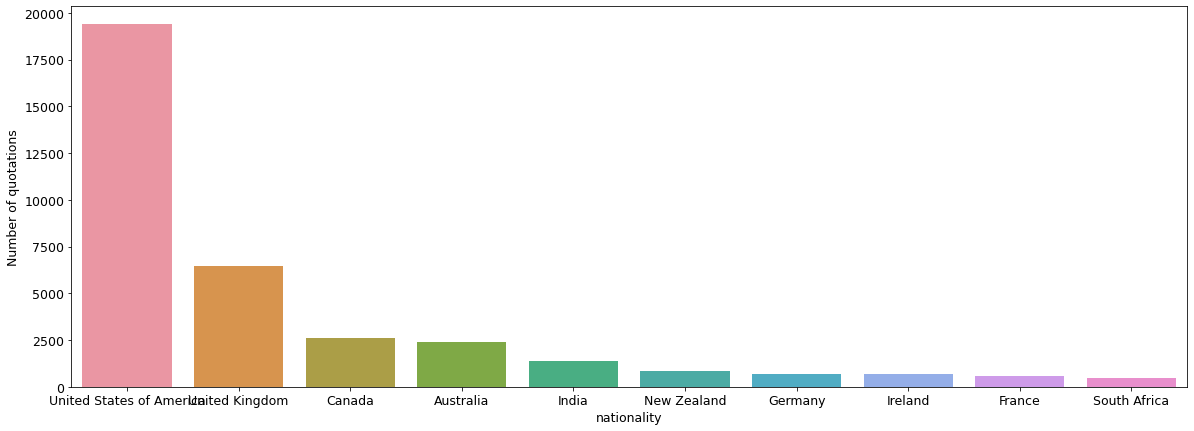

In [180]:
#Distribution of nationality

df_nationality = df_plot.groupby('nationality')['nationality'].count() \
            .reset_index(name='count') \
            .sort_values(['count'], ascending=False)
    
df_nationality['nationality'] = df_nationality['nationality'].apply(lambda x: df_lookup.loc[x]['Label'])
ax = sns.barplot(x="nationality", y="count",data=df_test[:10])
ax.set(ylabel='Number of quotations')

[Text(0, 0.5, 'Number of quotations')]

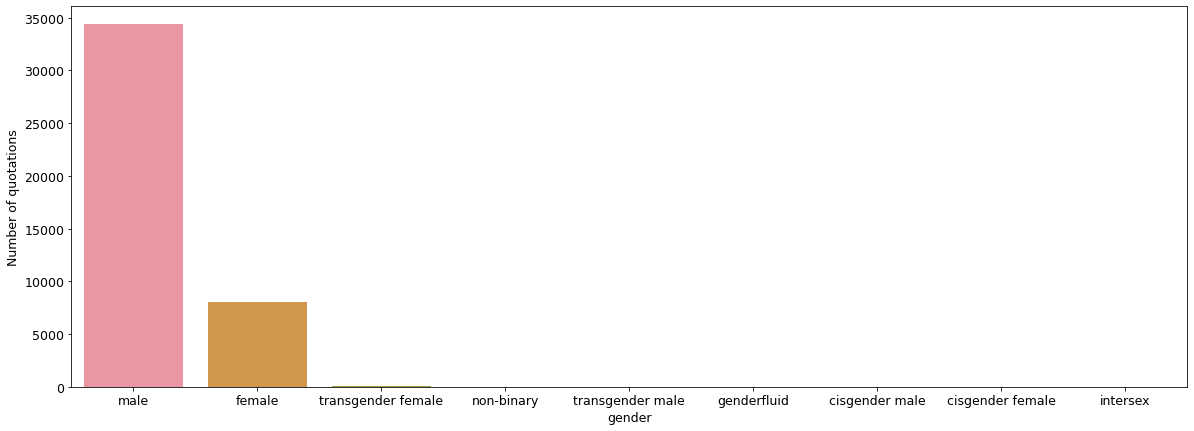

In [182]:
#Distribution of gender per quotation

df_gender = df_plot.groupby('gender')['gender'].count() \
            .reset_index(name='count') \
            .sort_values(['count'], ascending=False)
    
df_gender['gender'] = df_gender['gender'].apply(lambda x: df_lookup.loc[x]['Label'])
ax = sns.barplot(x="gender", y="count", data=df_gender[:10])
ax.set(ylabel='Number of quotations')

[Text(0, 0.5, 'Number of quotations')]

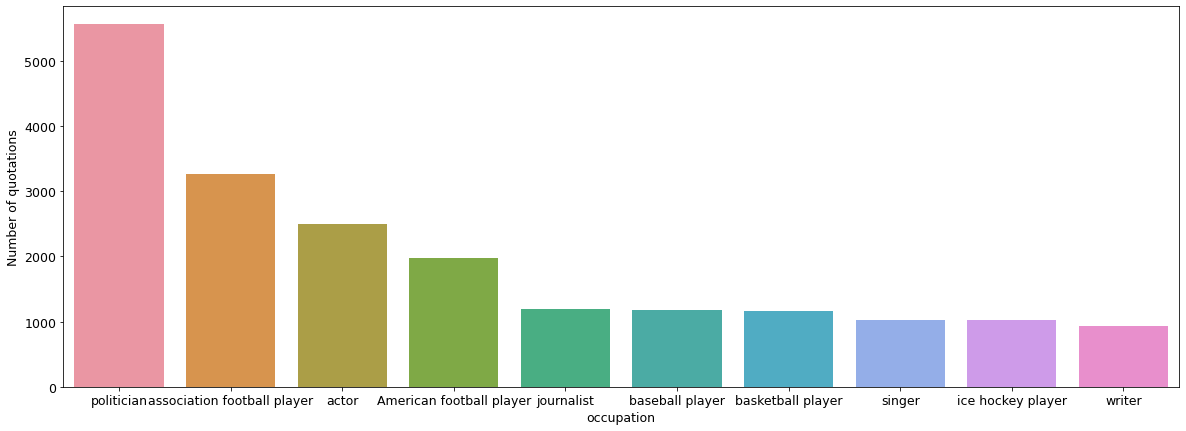

In [183]:
#Distribution of occupation

df_occupation = df_plot.groupby('occupation')['occupation'].count() \
            .reset_index(name='count') \
            .sort_values(['count'], ascending=False)
    
df_occupation['occupation'] = df_occupation['occupation'].apply(lambda x: df_lookup.loc[x]['Label'])
ax = sns.barplot(x="occupation", y="count", data=df_occupation[:10])
ax.set(ylabel='Number of quotations')

Appendix